Using TensorFlow backend.


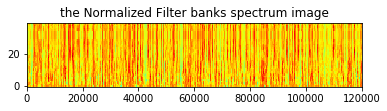

Filter banks shape: (119998, 40)


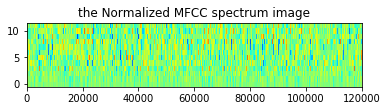

MFCCs shape: (119998, 12)


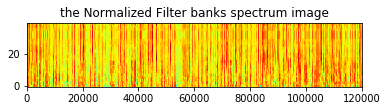

Filter banks shape: (119998, 40)


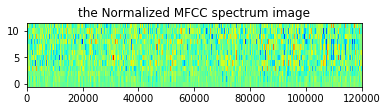

MFCCs shape: (119998, 12)


In [1]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plot
import tensorflow as tf
import keras
import librosa
import sklearn

%matplotlib inline

length_seconds = 10 * 60
pre_emphasis = 0.97
frame_size = 0.025
frame_stride = 0.01
NFFT = 512
nfilt = 40
num_ceps = 12
cep_lifter = 22
count_files = 2

for i in range(1, count_files + 1):
    filename = 'vid' + str(i) + '.wav'
    sample_rate, signal = scipy.io.wavfile.read(filename)  # File assumed to be in the same directory
    # signal = signal[0:int(length_seconds * sample_rate)]  # Keep the first 60 seconds

    # plot.plot(signal)
    # plot.show()

    emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # plot.plot(emphasized_signal)
    # plot.show()

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]

    plot.plot(frames[0])
    # plot.show()

    frames *= numpy.hamming(frame_length)

    # plot.plot(frames[0])
    # plot.show()

    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB
    filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

    plot.subplot(312)
    filter_banks -= (numpy.mean(filter_banks,axis=0) + 1e-8)
    plot.imshow(filter_banks.T, cmap=plot.cm.jet, aspect='auto')
    # plot.xticks(numpy.arange(0, (filter_banks.T).shape[1], int((filter_banks.T).shape[1] / 6)), ['0s', '0.5s', '1s', '1.5s','2.5s','3s','3.5'])
    ax = plot.gca()
    ax.invert_yaxis()
    plot.title('the Normalized Filter banks spectrum image')
    plot.show()
    print('Filter banks shape: ' + str(filter_banks.shape))

    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    (nframes, ncoeff) = mfcc.shape
    n = numpy.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
    mfcc *= lift  #*
    mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)

    plot.subplot(312)
    mfcc -= (numpy.mean(mfcc,axis=0) + 1e-8)
    plot.imshow(mfcc.T, cmap=plot.cm.jet, aspect='auto')
    # plot.xticks(numpy.arange(0, (mfcc.T).shape[1], int((mfcc.T).shape[1] / 6)), ['0s', '0.5s', '1s', '1.5s','2.5s','3s','3.5'])
    ax = plot.gca()
    ax.invert_yaxis()
    plot.title('the Normalized MFCC spectrum image')
    plot.show()
    print('MFCCs shape: ' + str(mfcc.shape))
